### **Author** : Lina Farchado

In [21]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
from typing import Iterable
import copy
import matplotlib.pyplot as plt
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [22]:
class SimpleCNN(nn.Module):
    def __init__(self, dataset):
        super(SimpleCNN, self).__init__()
        in_channels = 1 if dataset.lower() == 'mnist' else 3

        # Conv Layers
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels, 32, 3),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        
        # Compute input_size
        size = 28 if dataset.lower() == 'mnist' else 32
        x = torch.randn(1, in_channels, size, size)
        x = self.conv_layers(x)
        input_size = x.view(1, -1).size(1)
        
        # Dense layers
        self.fc_layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [23]:
def average_model_parameters(models, average_weight):
    params_list = [model.state_dict() for model in models]
    avg_params = {}
    for name, param in params_list[0].items():
        avg_params[name] = sum(average_weight * model.state_dict()[name] 
                             for model in models)
    
    return avg_params.values()

def update_model_parameters(model, parameters):
    state_dict = model.state_dict()
    for (name, _), param in zip(state_dict.items(), parameters):
        state_dict[name] = param
    model.load_state_dict(state_dict)

def client_update(model, dataloader):
    """
    Implementation of ClientUpdate from Algorithm 1
    """
    model.train()
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)
    
    for _ in range(20):
        for image, target in dataloader:
            image, target = image.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
    
    losses = []
    for epoch in range(20):
        total_loss = 0.0
        num_batches = 0
        for image, target in dataloader:
            image, target = image.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(image)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            num_batches += 1
            
        losses.append(total_loss / num_batches)
    
    return model, losses

def evaluate_model(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    criterion = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for image, target in test_loader:
            image, target = image.to(device), target.to(device)
            output = model(image)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            
    test_loss /= len(test_loader)
    accuracy = 100. * correct / len(test_loader.dataset)
    return test_loss, accuracy

In [24]:
def setup_dataset(dataset_name, subset_size):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)) if dataset_name == 'mnist'
        else transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])
    dataset_class = torchvision.datasets.MNIST if dataset_name == 'mnist' else torchvision.datasets.CIFAR10
    full_dataset = dataset_class('./data', train=True, download=True, transform=transform)
    
    indices = torch.randperm(len(full_dataset))
    subset1 = Subset(full_dataset, indices[:subset_size])
    subset2 = Subset(full_dataset, indices[subset_size:2*subset_size])
    
    loader1 = DataLoader(subset1, batch_size=50, shuffle=True)
    loader2 = DataLoader(subset2, batch_size=50, shuffle=True)
    test_loader = DataLoader(dataset_class('./data', train=False, transform=transform), batch_size=100)
    
    return loader1, loader2, test_loader

def run_experiment(dataset_name, subset_size = 600, common_init = True):
    """Run federated learning experiment following requirements"""

    loader1, loader2, test_loader = setup_dataset(dataset_name, subset_size)
    
    # Initialize models
    if common_init:
        base_model = SimpleCNN(dataset_name).to(device)
        model1 = copy.deepcopy(base_model)
        model2 = copy.deepcopy(base_model)
    else:
        model1 = SimpleCNN(dataset_name).to(device)
        model2 = SimpleCNN(dataset_name).to(device)
    
    # Train models and store losses
    model1, losses1 = client_update(model1, loader1)
    model2, losses2 = client_update(model2, loader2)
    
    training_losses = {
        'model1': losses1,
        'model2': losses2
    }
    
    # Create and update averaged model with weight 1/2
    averaged_params = average_model_parameters([model1, model2], 0.5)
    
    averaged_model = SimpleCNN(dataset_name).to(device)
    update_model_parameters(averaged_model, averaged_params)
    
    results = {
        'model1': evaluate_model(model1, test_loader),
        'model2': evaluate_model(model2, test_loader),
        'averaged': evaluate_model(averaged_model, test_loader)
    }
    
    return results


def experiment_with_different_sizes(dataset):
    """Run experiments with different subset sizes"""
    subset_sizes = [600, 300, 150, 75]
    
    results = {
        'common_init': {},
        'separate_init': {}
    }
    
    for size in subset_sizes:
        print(f"\nTesting with subset size: {size}")
        
        # Without common initialization
        print("Without common initialization:")
        results['separate_init'][size] = run_experiment(dataset, size, common_init=False)
        
        # With common initialization
        print("With common initialization:")
        results['common_init'][size] = run_experiment(dataset, size, common_init=True)
        
        # Print results
        for init_type, size_results in results.items():
            for model_type, (loss, acc) in size_results[size].items():
                print(f"{init_type} - {model_type}: "
                      f"Loss: {loss:.4f}, Accuracy: {acc:.2f}%")
    
    return results

In [25]:
def plot_training_loss(losses1, losses2, title):
    plt.figure(figsize=(10, 6))
    plt.plot(losses1, label='Model 1', marker='o')
    plt.plot(losses2, label='Model 2', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss - {title}')
    plt.legend()
    plt.grid(True)
    plt.show()

def plot_results(results, dataset_name):
    plt.figure(figsize=(12, 6))
    
    # Extract subset sizes and accuracies
    sizes = sorted(list(results['common_init'].keys()))
    
    # Common initialization accuracies
    common_init_acc = [results['common_init'][size]['averaged'][1] for size in sizes]
    separate_init_acc = [results['separate_init'][size]['averaged'][1] for size in sizes]
    
    # Plot both initialization methods
    plt.plot(sizes, common_init_acc, 'bo-', label='Common Initialization', linewidth=2)
    plt.plot(sizes, separate_init_acc, 'ro-', label='Separate Initialization', linewidth=2)
    
    # Add individual model accuracies
    common_init_m1 = [results['common_init'][size]['model1'][1] for size in sizes]
    common_init_m2 = [results['common_init'][size]['model2'][1] for size in sizes]
    separate_init_m1 = [results['separate_init'][size]['model1'][1] for size in sizes]
    separate_init_m2 = [results['separate_init'][size]['model2'][1] for size in sizes]
    
    plt.plot(sizes, common_init_m1, 'b--', alpha=0.5, label='Common Init - Model 1')
    plt.plot(sizes, common_init_m2, 'b:', alpha=0.5, label='Common Init - Model 2')
    plt.plot(sizes, separate_init_m1, 'r--', alpha=0.5, label='Separate Init - Model 1')
    plt.plot(sizes, separate_init_m2, 'r:', alpha=0.5, label='Separate Init - Model 2')
    
    plt.xscale('log')
    plt.xlabel('Subset Size')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Model Performance on {dataset_name.upper()} Dataset')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

def compare_init_methods(results, dataset_name, subset_size):
    plt.figure(figsize=(10, 6))
    
    # Extract accuracies for the specified subset size
    common_init = results['common_init'][subset_size]
    separate_init = results['separate_init'][subset_size]
    
    labels = ['Model 1', 'Model 2', 'Averaged']
    common_acc = [common_init['model1'][1], common_init['model2'][1], common_init['averaged'][1]]
    separate_acc = [separate_init['model1'][1], separate_init['model2'][1], separate_init['averaged'][1]]
    
    x = np.arange(len(labels))
    width = 0.35
    
    plt.bar(x - width/2, common_acc, width, label='Common Initialization')
    plt.bar(x + width/2, separate_acc, width, label='Separate Initialization')
    
    plt.xlabel('Model')
    plt.ylabel('Accuracy (%)')
    plt.title(f'Comparison of Initialization Methods\n{dataset_name.upper()} - Subset Size: {subset_size}')
    plt.xticks(x, labels)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


Running experiments on MNIST

Testing with subset size: 600
Without common initialization:
With common initialization:
common_init - model1: Loss: 0.3269, Accuracy: 93.74%
common_init - model2: Loss: 0.3252, Accuracy: 93.37%
common_init - averaged: Loss: 0.5595, Accuracy: 87.14%
separate_init - model1: Loss: 0.3260, Accuracy: 93.04%
separate_init - model2: Loss: 0.2895, Accuracy: 93.85%
separate_init - averaged: Loss: 1.0393, Accuracy: 91.31%

Testing with subset size: 300
Without common initialization:
With common initialization:
common_init - model1: Loss: 0.5164, Accuracy: 88.30%
common_init - model2: Loss: 0.4257, Accuracy: 89.66%
common_init - averaged: Loss: 0.3862, Accuracy: 89.78%
separate_init - model1: Loss: 0.4787, Accuracy: 89.29%
separate_init - model2: Loss: 0.4340, Accuracy: 88.95%
separate_init - averaged: Loss: 1.1580, Accuracy: 83.24%

Testing with subset size: 150
Without common initialization:
With common initialization:
common_init - model1: Loss: 0.5192, Accuracy

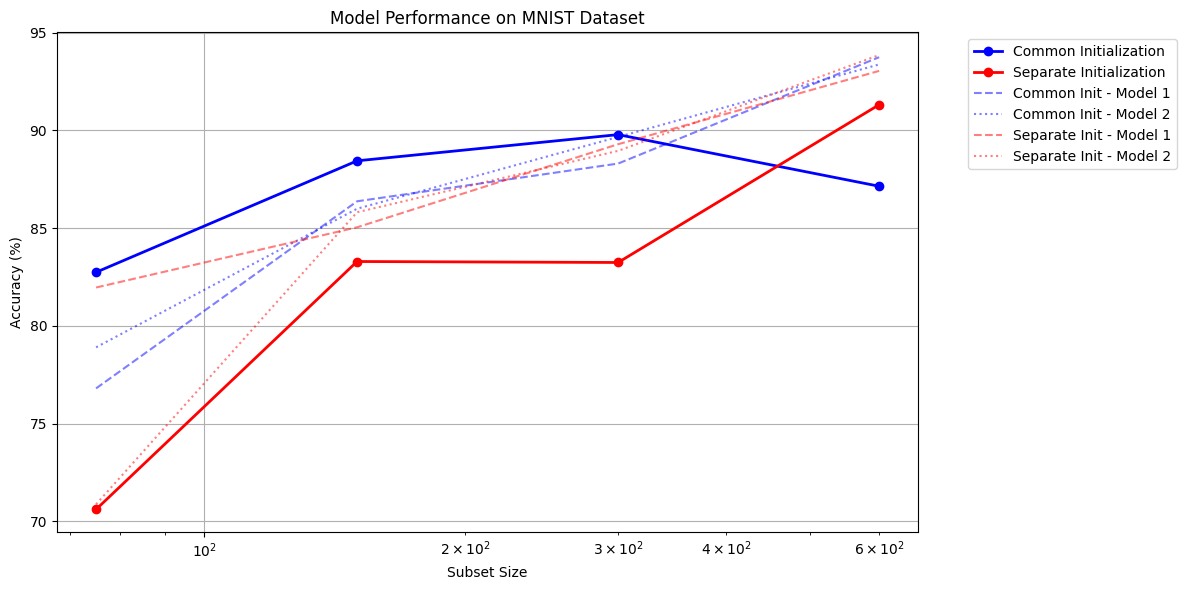

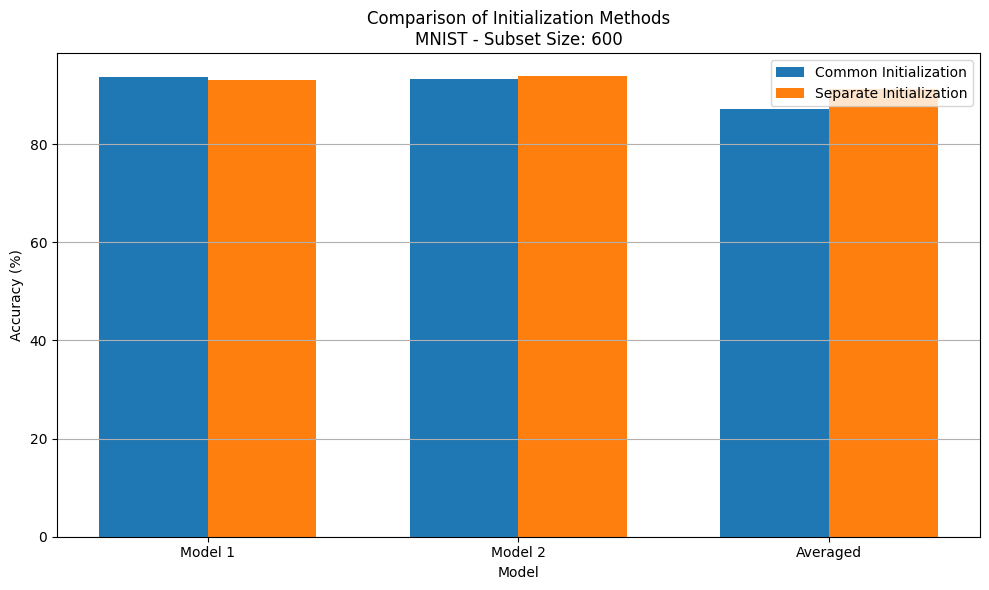

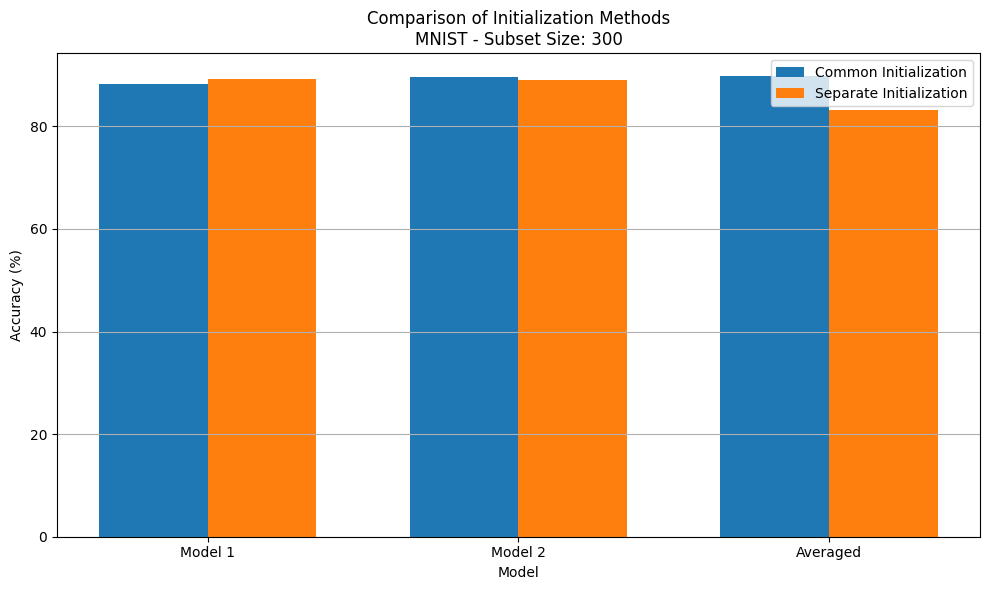

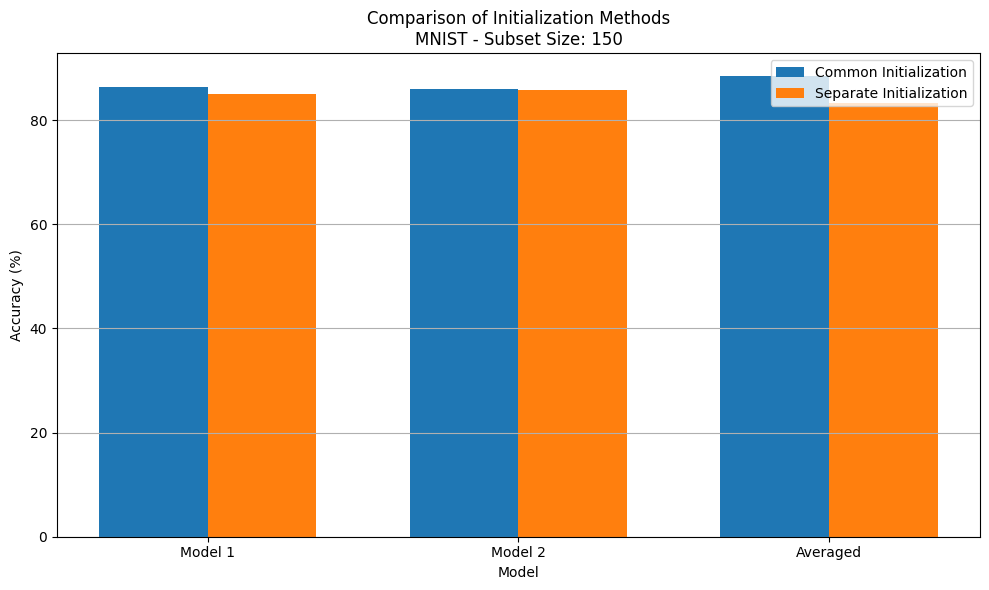

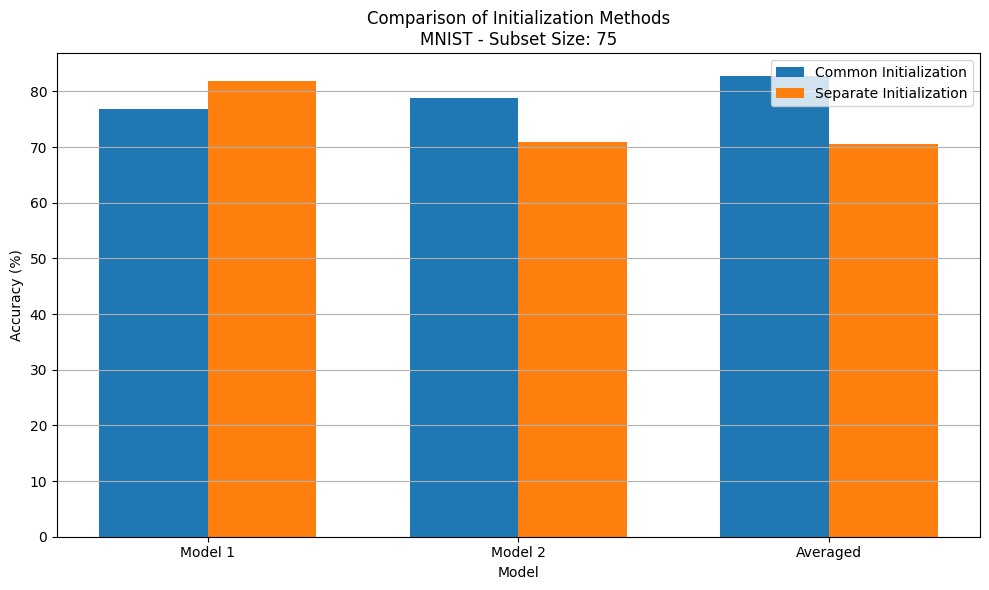


Running experiments on CIFAR10

Testing with subset size: 600
Without common initialization:
Files already downloaded and verified
With common initialization:
Files already downloaded and verified
common_init - model1: Loss: 3.6334, Accuracy: 35.59%
common_init - model2: Loss: 3.5733, Accuracy: 37.11%
common_init - averaged: Loss: 2.6963, Accuracy: 40.67%
separate_init - model1: Loss: 3.6905, Accuracy: 36.70%
separate_init - model2: Loss: 3.4151, Accuracy: 35.78%
separate_init - averaged: Loss: 1.9378, Accuracy: 35.26%

Testing with subset size: 300
Without common initialization:
Files already downloaded and verified
With common initialization:
Files already downloaded and verified
common_init - model1: Loss: 3.0189, Accuracy: 31.28%
common_init - model2: Loss: 3.0804, Accuracy: 32.23%
common_init - averaged: Loss: 2.3252, Accuracy: 36.59%
separate_init - model1: Loss: 3.2320, Accuracy: 26.55%
separate_init - model2: Loss: 3.0731, Accuracy: 31.33%
separate_init - averaged: Loss: 2.082

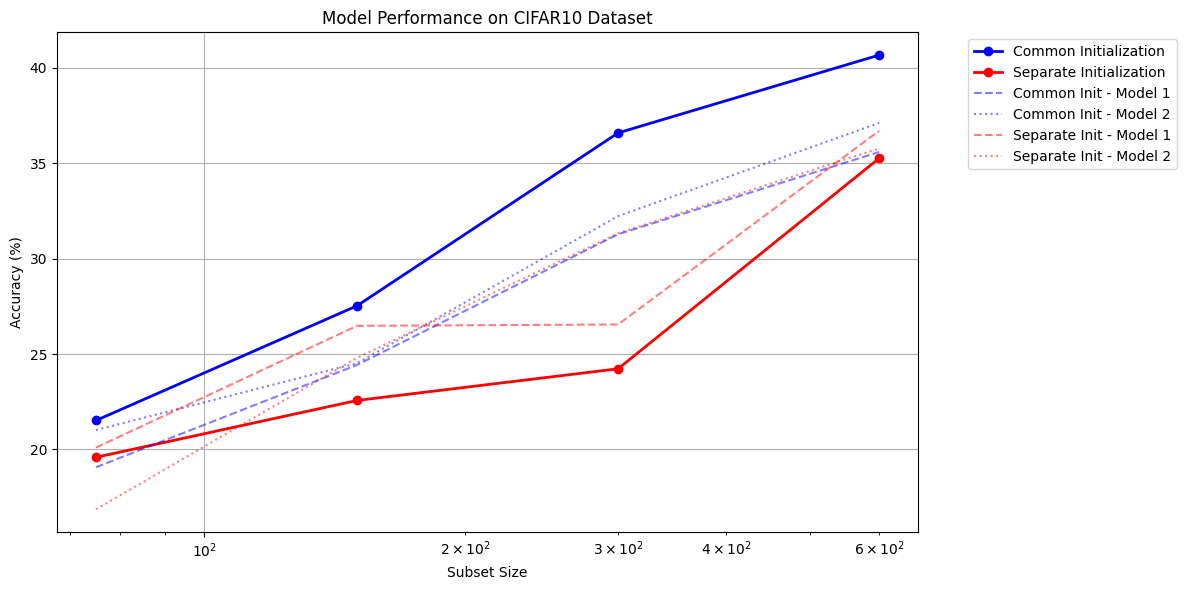

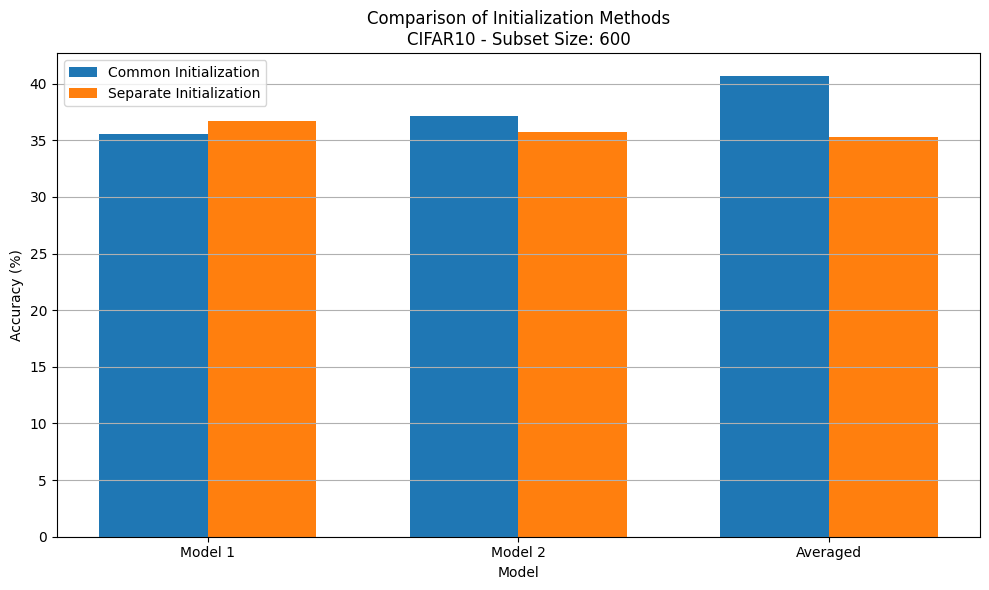

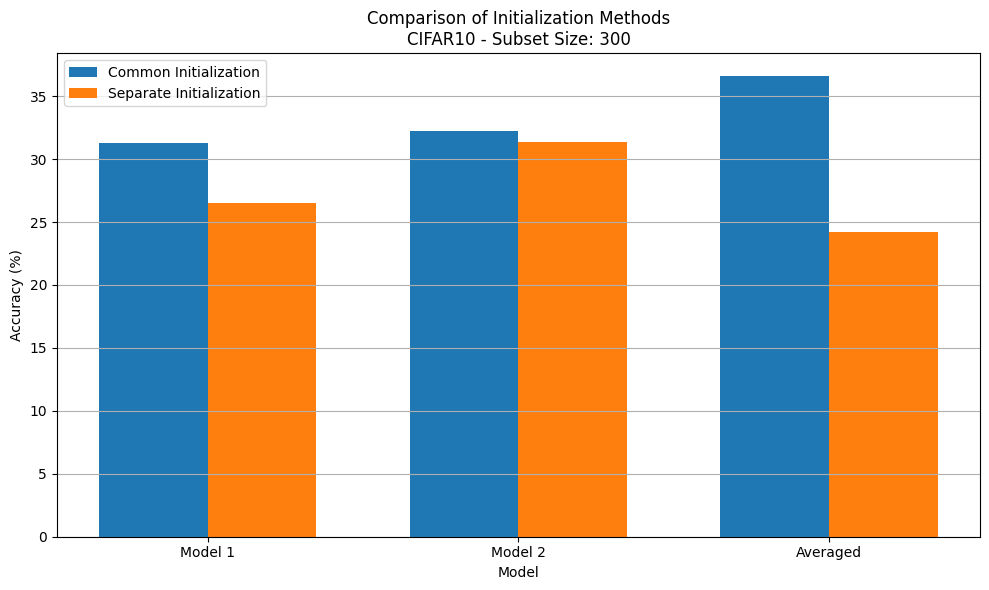

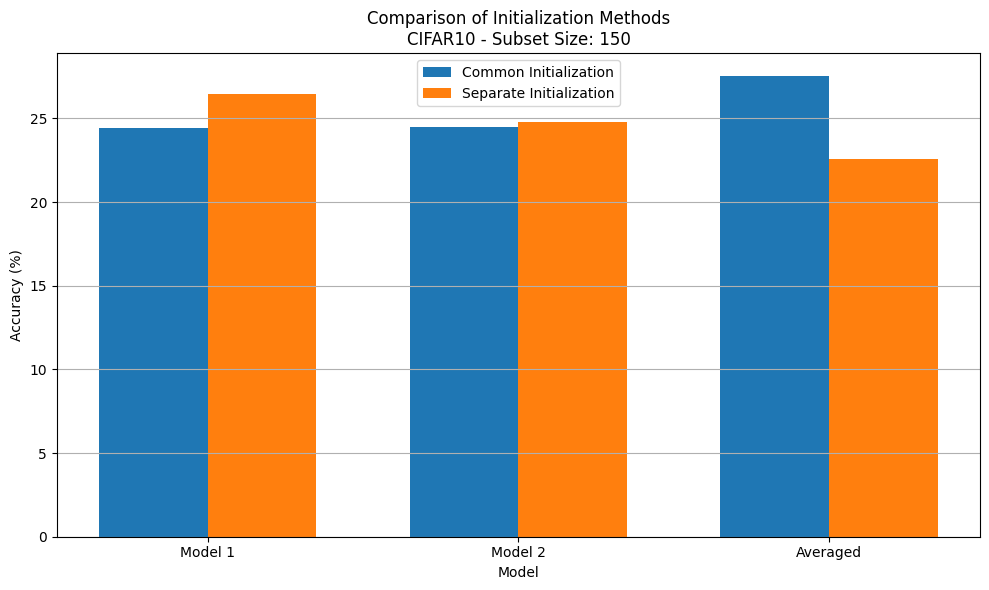

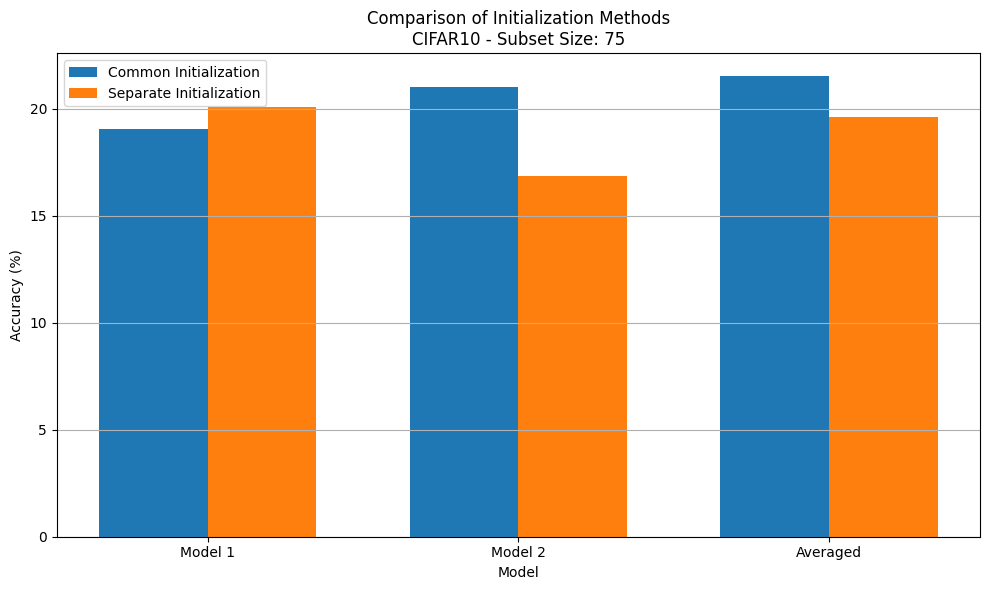

In [26]:
for dataset in ['mnist', 'cifar10']:
    print(f"\nRunning experiments on {dataset.upper()}")
    results = experiment_with_different_sizes(dataset)
    
    # Plot the results
    plot_results(results, dataset)
    
    # Compare initialization methods for each subset size
    for size in [600, 300, 150, 75]:
        compare_init_methods(results, dataset, size)
        
    # Get training losses from the last run
    last_run = results['common_init'][600]
    if 'training_losses' in last_run:
        plot_training_loss(
            last_run['training_losses']['model1'],
            last_run['training_losses']['model2'],
            f'{dataset.upper()} - Subset Size 600'
        )